## Load tokenizer

In [1]:
from datasets import load_dataset

from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import json

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ---------- Preprocesing Functions ----------
def preprocess_paradetox_multilingual(example):
    return {
        "input_text": "detoxify: " + example["toxic_sentence"],
        "target_text": example["neutral_sentence"]
    }

def preprocess_paradetox(example):
    return {
        "input_text": "detoxify: " + example["en_toxic_comment"],
        "target_text": example["en_neutral_comment"]
    }

def clean_columns(dataset):
    return dataset.remove_columns(
        [col for col in dataset.column_names if col not in ["input_text", "target_text"]]
    )


def load_json_results(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        return json.load(f)


def save_variables_to_json(filename, **variables):
    """
    Saves given variables to a JSON file with their variable names as keys.

    Parameters:
    - filename (str): The name of the JSON file to write to.
    - **variables: Arbitrary keyword arguments representing variable names and their values.
    """
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(variables, f, ensure_ascii=False, indent=2)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Load and Process Datasets

In [2]:
# ---------- Load and Process Datasets ----------
test_data_en = load_dataset("textdetox/multilingual_paradetox", split="en")
test_data_de = load_dataset("textdetox/multilingual_paradetox", split="de")
train_data = load_dataset("s-nlp/paradetox", split="train") 

## format datasets remove emoji

In [3]:
import re

formatted_train = clean_columns(train_data.map(preprocess_paradetox))
formatted_en = clean_columns(test_data_en.map(preprocess_paradetox_multilingual))
formatted_de = clean_columns(test_data_de.map(preprocess_paradetox_multilingual))


def remove_emojis(text):
    # This regex pattern matches a wide range of emojis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags
        "\U00002700-\U000027BF"  # Dingbats
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U00002600-\U000026FF"  # Miscellaneous Symbols
        "\U0001F700-\U0001F77F"  # Alchemical Symbols
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def clean_emoji_batch(batch):
    batch["input_text"] = remove_emojis(batch["input_text"])
    batch["target_text"] = remove_emojis(batch["target_text"])
    return batch

formatted_train = formatted_train.map(clean_emoji_batch)
formatted_en = formatted_en.map(clean_emoji_batch)
formatted_de = formatted_de.map(clean_emoji_batch)


In [4]:
print("Test dataset en size:", len(formatted_en))
print("Test dataset de size:", len(formatted_de))
print("Train dataset size:", len(formatted_train))

print("Test en dataset columns:", formatted_en.column_names)
print("Test de dataset columns:", formatted_de.column_names)
print("Train dataset columns:", formatted_train.column_names)

Test dataset en size: 400
Test dataset de size: 400
Train dataset size: 19744
Test en dataset columns: ['input_text', 'target_text']
Test de dataset columns: ['input_text', 'target_text']
Train dataset columns: ['input_text', 'target_text']


## Save datasets to json

In [6]:
save_variables_to_json(
    "formatted_de.json",
    input_texts=formatted_de["input_text"],
    reference_texts=formatted_de["target_text"],
)

save_variables_to_json(
    "formatted_en.json",
    input_texts=formatted_en["input_text"],
    reference_texts=formatted_en["target_text"],
)

save_variables_to_json(
    "formatted_train.json",
    input_texts=formatted_train["input_text"],
    reference_texts=formatted_train["target_text"],
)

## Load Dataset

In [5]:
import json
from datasets import Dataset

def load_formatted_json(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Convert keys to the structure used by your pipeline
    input_texts = data["input_texts"]
    target_texts = data["reference_texts"]

    return Dataset.from_dict({
        "input_text": input_texts,
        "target_text": target_texts
    })

formatted_train = load_formatted_json("formatted_train.json")
formatted_de = load_formatted_json("formatted_de.json")
formatted_en = load_formatted_json("formatted_en.json")

## Evaluate Toxicity before

In [33]:
def evaluate_toxicity_from_json(file_path: str, input_key: str = "input_texts", prefix_to_strip: str = "detoxify: "):
    """
    Loads a JSON file with a dictionary of lists, classifies toxicity, and prints stats.
    """
    # Load dataset
    with open(file_path, "r", encoding="utf-8") as f:
        dataset = json.load(f)

    # Directly access the list under the input_key
    input_texts = [text.replace(prefix_to_strip, "") for text in dataset[input_key]]

    print(f"✅ Loaded {len(input_texts)} texts from {file_path}")

    # Run classification in batches
    batch_size = 16
    toxic_count = 0
    non_toxic_count = 0

    for i in range(0, len(input_texts), batch_size):
        batch = input_texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)

        for label in predictions:
            if label.item() == 0:
                non_toxic_count += 1
            else:
                toxic_count += 1

    total = toxic_count + non_toxic_count
    print("\n--- Toxicity Evaluation ---")
    print(f"Total inputs evaluated: {total}")
    print(f"Non-toxic: {non_toxic_count} ({(non_toxic_count / total) * 100:.2f}%)")
    print(f"Toxic: {toxic_count} ({(toxic_count / total) * 100:.2f}%)")


In [34]:
evaluate_toxicity_from_json("formatted_en.json")
evaluate_toxicity_from_json("formatted_de.json")

✅ Loaded 400 texts from formatted_en.json

--- Toxicity Evaluation ---
Total inputs evaluated: 400
Non-toxic: 31 (7.75%)
Toxic: 369 (92.25%)
✅ Loaded 400 texts from formatted_de.json

--- Toxicity Evaluation ---
Total inputs evaluated: 400
Non-toxic: 109 (27.25%)
Toxic: 291 (72.75%)


In [28]:
def tokenize(examples):
    # Tokenize inputs
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=128,
        padding="max_length",
        truncation=True
    )

    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["target_text"],
            max_length=128,
            padding="max_length",
            truncation=True
        )

    # Mask padding tokens in labels
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label_seq]
        for label_seq in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize dataset
tokenized_dataset = formatted_train.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.filter(lambda x: any(label != -100 for label in x["labels"]))

tokenized_eval = formatted_en.map(tokenize, batched=True)
tokenized_eval = tokenized_eval.filter(lambda x: any(label != -100 for label in x["labels"]))

# Assign to eval_dataset
eval_dataset = tokenized_eval
train_dataset = tokenized_dataset

Map:   0%|          | 0/19744 [00:00<?, ? examples/s]

c:\Users\jonaz\git\Maria_stuff\Maria_code\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:4109: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Filter:   0%|          | 0/19744 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

In [13]:
print("Train dataset size:", len(train_dataset))
print("Eval dataset size:", len(eval_dataset))

print(type(eval_dataset))
print(eval_dataset[1])

print(type(train_dataset))
print(train_dataset[1])

Train dataset size: 19744
Eval dataset size: 400
<class 'datasets.arrow_dataset.Dataset'>
{'input_text': "detoxify: My page should be protected first so that worthless scum like you can't keep vandalizing it.", 'target_text': "My page should be protected first so that unpleasant people like you can't keep vandalizing it.", 'input_ids': [16379, 4921, 10, 499, 543, 225, 36, 5046, 166, 78, 24, 1494, 924, 3, 7, 6361, 114, 25, 54, 31, 17, 453, 4049, 26, 138, 2610, 34, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Models

## old transformer model

In [14]:
from transformers import (
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
    Seq2SeqTrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Seq2SeqTrainer,
)
import torch
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5-detox-en-finetuned",
    overwrite_output_dir=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    num_train_epochs=3,
    fp16=torch.cuda.is_available(),
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs_en_refined",
    report_to="none"
)

# ✅ Custom Trainer with full-batch penalty, lambda warmup, and logging
class ToxicityPenaltyTrainer(Seq2SeqTrainer):
    def __init__(self, *args, lambda_penalty=1.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda_penalty = lambda_penalty
        self.tox_tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
        self.tox_model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert").to(self.model.device)
        self.tox_model.eval()
        self.current_step = 0  # For lambda warmup
        self.penalty_log = []

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        generation_loss = outputs.loss

        # Full batch generation for penalty
        sample_input_ids = inputs["input_ids"]
        sample_attention_mask = inputs["attention_mask"]

        self.current_step += 1
        warmup_steps = 500
        current_lambda = min(self.lambda_penalty, self.lambda_penalty * self.current_step / warmup_steps)

        with torch.no_grad():
            generated_ids = model.generate(
                input_ids=sample_input_ids,
                attention_mask=sample_attention_mask,
                max_length=30,
                num_beams=4, 
                do_sample=False,
                early_stopping=True,
                decoder_start_token_id=self.tokenizer.pad_token_id
            )

            decoded_texts = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            tox_inputs = self.tox_tokenizer(decoded_texts, return_tensors="pt", truncation=True, padding=True).to(self.model.device)
            tox_logits = self.tox_model(**tox_inputs).logits
            tox_probs = torch.sigmoid(tox_logits[:, 0])
            penalty = tox_probs.mean()

        # Log penalty score
        self.log({"penalty_score": penalty.item()})
        self.penalty_log.append({
            "penalty_score": penalty.item(),
            "generation_loss": generation_loss.item(),
            "step": self.state.global_step,
            "epoch": self.state.epoch
        })

        # Scaled penalty
        penalty_weight = torch.tanh(current_lambda * penalty)
        total_loss = generation_loss + penalty_weight
        return (total_loss, outputs) if return_outputs else total_loss

# ✅ Instantiate and train
trainer = ToxicityPenaltyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    lambda_penalty=0.9
)

trainer.train()

  0%|          | 0/3702 [00:00<?, ?it/s]

{'penalty_score': 0.8384648561477661, 'epoch': 0}
{'penalty_score': 0.7225239276885986, 'epoch': 0}
{'penalty_score': 0.7299094200134277, 'epoch': 0.0}
{'penalty_score': 0.9040523767471313, 'epoch': 0.0}
{'penalty_score': 0.6879165172576904, 'epoch': 0.0}
{'penalty_score': 0.6071668863296509, 'epoch': 0.0}
{'penalty_score': 0.8161963224411011, 'epoch': 0.0}
{'penalty_score': 0.677609920501709, 'epoch': 0.0}
{'penalty_score': 0.6595351696014404, 'epoch': 0.0}
{'penalty_score': 0.8427661657333374, 'epoch': 0.0}
{'penalty_score': 0.7256010174751282, 'epoch': 0.0}
{'penalty_score': 0.4845339059829712, 'epoch': 0.0}
{'penalty_score': 0.8149999380111694, 'epoch': 0.0}
{'penalty_score': 0.7716923356056213, 'epoch': 0.0}
{'penalty_score': 0.6034647822380066, 'epoch': 0.01}
{'penalty_score': 0.653598427772522, 'epoch': 0.01}
{'penalty_score': 0.49958038330078125, 'epoch': 0.01}
{'penalty_score': 0.8837884664535522, 'epoch': 0.01}


KeyboardInterrupt: 

## Finetuned Finetuned

In [ ]:
# from transformers import (
#     DataCollatorForSeq2Seq,
#     EarlyStoppingCallback,
#     Seq2SeqTrainingArguments,
#     AutoTokenizer,
#     AutoModelForSequenceClassification,
#     Seq2SeqTrainer,
# )
# from datasets import Dataset
# import torch
# import warnings

# warnings.filterwarnings("ignore", category=FutureWarning)

# # Ensure decoder start token is set
# if model.config.decoder_start_token_id is None:
#     model.config.decoder_start_token_id = tokenizer.pad_token_id

# # Data collator
# data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# # Training arguments
# training_args = Seq2SeqTrainingArguments(
#     output_dir="./mt5-detox-en-finetuned_2",
#     overwrite_output_dir=True,
#     per_device_train_batch_size=8,
#     gradient_accumulation_steps=2,
#     learning_rate=3e-5,
#     num_train_epochs=3,
#     fp16=torch.cuda.is_available(),
#     save_strategy="epoch",
#     eval_strategy="epoch",
#     logging_strategy="steps",
#     logging_steps=100,
#     save_total_limit=2,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_loss",
#     greater_is_better=False,
#     logging_dir="./logs_en_refined",
#     report_to="none",
#     label_smoothing_factor=0.1,
#     generation_num_beams=4  # Ensure compatibility with early_stopping
# )

# # Custom Trainer
# class ToxicityPenaltyTrainer(Seq2SeqTrainer):
#     def __init__(self, *args, lambda_penalty=1.5, penalty_interval=1, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.lambda_penalty = lambda_penalty
#         self.penalty_interval = penalty_interval
#         self.tox_tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
#         self.tox_model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert").to(self.model.device)
#         self.tox_model.eval()
#         self.current_step = 0
#         self.penalty_log = []

#     def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
#         outputs = model(**inputs)
#         generation_loss = outputs.loss

#         self.current_step += 1
#         warmup_steps = 500
#         current_lambda = self.lambda_penalty * min(1.0, (self.current_step / warmup_steps)) ** 0.7

#         if self.current_step % self.penalty_interval == 0:
#             with torch.no_grad():
#                 generated_ids = model.generate(
#                     input_ids=inputs["input_ids"],
#                     attention_mask=inputs["attention_mask"],
#                     max_length=30,
#                     num_beams=4,
#                     do_sample=False,
#                     early_stopping=True,
#                     decoder_start_token_id=self.tokenizer.pad_token_id
#                 )

#                 decoded_texts = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
#                 tox_inputs = self.tox_tokenizer(
#                     decoded_texts,
#                     return_tensors="pt",
#                     truncation=True,
#                     padding=True
#                 ).to(self.model.device)

#                 tox_logits = self.tox_model(**tox_inputs).logits
#                 tox_probs = torch.sigmoid(tox_logits[:, 0])
#                 penalty = tox_probs.mean()
#         else:
#             penalty = torch.tensor(0.0, device=self.model.device)

#         self.log({"penalty_score": penalty.item()})
#         self.penalty_log.append({
#             "penalty_score": penalty.item(),
#             "generation_loss": generation_loss.item(),
#             "step": self.state.global_step,
#             "epoch": self.state.epoch
#         })

#         total_loss = generation_loss + current_lambda * penalty
#         return (total_loss, outputs) if return_outputs else total_loss

# """ # Reduce dataset size for quick testing
# if isinstance(train_dataset, dict):
#     train_dataset = Dataset.from_dict(train_dataset)
# train_dataset = train_dataset.select(range(min(500, len(train_dataset)))) """

# # Instantiate and train
# trainer = ToxicityPenaltyTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
#     lambda_penalty=1.5
# )

# trainer.train()


In [7]:
import matplotlib.pyplot as plt
import json

# Save logs to JSON
with open("trainer_log.json", "w", encoding="utf-8") as f:
    json.dump(trainer.state.log_history, f, indent=2)

# ✅ Now read logs back from file
with open("trainer_log.json", "r", encoding="utf-8") as f:
    logs = json.load(f)

# Extract and plot penalty scores
penalties = [log["penalty_score"] for log in logs if "penalty_score" in log]
plt.plot(penalties)
plt.xlabel("Training step")
plt.ylabel("Penalty Score")
plt.title("Toxicity Penalty Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'trainer' is not defined

## Load model

In [8]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Path to your saved model
checkpoint_path = "mt5-detox-en-finetuned_2/checkpoint-3702"

# Load model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(checkpoint_path)
model = T5ForConditionalGeneration.from_pretrained(checkpoint_path)

# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

## English Translation

In [45]:
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm
import json

# Load German-to-English model
model_name = "Helsinki-NLP/opus-mt-de-en"
tokenizer_mt = MarianTokenizer.from_pretrained(model_name)
model_mt = MarianMTModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Use formatted_de directly (already loaded as a Dataset)
toxic_de = [text.replace("detoxify: ", "") for text in formatted_de["input_text"]]
neutral_de = list(formatted_de["target_text"])

# Helper to batch translate a list of strings
def batch_translate(texts, batch_size=8):
    translations = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        inputs = tokenizer_mt(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(model_mt.device)
        outputs = model_mt.generate(**inputs, max_length=128)
        decoded = tokenizer_mt.batch_decode(outputs, skip_special_tokens=True)
        translations.extend(decoded)
    return translations

# Translate both
toxic_en = batch_translate(toxic_de)
neutral_en = batch_translate(neutral_de)

# Reconstruct translated dataset
translated_data = [
    {"input_text": "detoxify: " + toxic, "target_text": neutral}
    for toxic, neutral in zip(toxic_en, neutral_en)
]

# Save to file
with open("translated_de_to_en_pairs.json", "w", encoding="utf-8") as f:
    json.dump(translated_data, f, indent=2, ensure_ascii=False)

print("✅ Translated dataset saved.")

100%|██████████| 50/50 [00:25<00:00,  1.99it/s]

✅ Translated dataset saved.


## Load German translated to english Dataset

In [9]:
from datasets import Dataset
import json

# Load raw list of strings
with open("translated_de_to_en_pairs.json", "r", encoding="utf-8") as f:
    raw_texts = json.load(f)

print("Raw texts loaded:", (raw_texts))

# Wrap each string in a dictionary
data = [
    {
        "input_text": entry.get("input_text", ""),
        "target_text": entry.get("target_text", "")
    }
    for entry in raw_texts
]

eval_dataset_de = data

print(type(eval_dataset_de))         
print(type(eval_dataset_de[0]))      

Raw texts loaded: [{'input_text': 'detoxify: #Land of the idiots #mental illness - "fight gg #Trump" (gg #Putin anyway) German # Regime in megalomania ....', 'target_text': '"Battle gg #Trump" (gg #Putin anyway) German # Regime in megalomania ....'}, {'input_text': "detoxify: #Lindner's got his head in the ass of #Merkel disgusting #FDP tonight", 'target_text': '#Lindner flatters himself again tonight #Merkel #FDP'}, {'input_text': "detoxify: Whether it's Merkel or Schulz? We Germans don't want to and can't hear this moron of plague (Merkel) and cholera (Schulz) anymore!", 'target_text': "Whether it's Merkel or Schulz? We Germans don't want and can't hear this talk from Merkel and Schulz anymore!"}, {'input_text': 'detoxify: Such a shabby rag, leaves children alone in war and flag flight', 'target_text': 'Such a person, leaves children in war alone and flag flight'}, {'input_text': "detoxify: I don't think the majority of the population is stupid or just come to your appearances?", 'ta

# Detoxification of Dataset

In [11]:
import json
from torch.utils.data import DataLoader
from transformers import T5Tokenizer
from tqdm import tqdm

def evaluate_and_save_detoxification(
    model,
    dataset,
    output_path,
    tokenizer=None,
    batch_size=12,
    lang="en"
):
    """
    Evaluates a detoxification model and saves results to a JSON file.
    
    Args:
        model: Trained T5 detoxification model.
        dataset: HuggingFace Dataset with "input_text" and "target_text".
        output_path: Path to save the JSON results.
        tokenizer: Optional tokenizer, default is T5.
        batch_size: Batch size for generation.
        lang: Language tag for progress bar.
    
    Returns:
        None
    """
    tokenizer = tokenizer or T5Tokenizer.from_pretrained("t5-small")

    def collate_fn(batch):
        texts = [ex["input_text"] for ex in batch]
        return tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)

    input_texts = []
    reference_texts = []
    detoxified_outputs = []

    model.eval()
    for i, batch in enumerate(tqdm(loader, desc=f"Generating Detoxified ({lang})")):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model.generate(
            **batch,
            max_length=50,
            num_beams=4,
            early_stopping=True,
            decoder_start_token_id=tokenizer.pad_token_id
        )

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        detoxified_outputs.extend(decoded)

        for j in range(len(decoded)):
            example = dataset[i * batch_size + j]
            input_texts.append(example["input_text"])
            reference_texts.append(example.get("target_text", ""))

    # Save results to JSON
    result = {
        "input_texts": input_texts,
        "reference_texts": reference_texts,
        "detoxified_outputs": detoxified_outputs
    }
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(result, f, ensure_ascii=False, indent=2)

    print(f"✅ Saved detoxified outputs to {output_path}")


In [13]:
# For English
evaluate_and_save_detoxification(
    model=model,
    dataset=eval_dataset,
    output_path="detoxified_outputs_en.json",
    tokenizer=tokenizer,
    lang="en"
)

Generating Detoxified (en): 100%|██████████| 34/34 [00:13<00:00,  2.50it/s]

✅ Saved detoxified outputs to detoxified_outputs_en.json


In [12]:
# For German
evaluate_and_save_detoxification(
    model=model,
    dataset=eval_dataset_de,  # or eval_dataset
    output_path="detoxified_outputs_de.json",
    tokenizer=tokenizer,
    lang="de"
)

Generating Detoxified (de): 100%|██████████| 34/34 [00:21<00:00,  1.60it/s]

✅ Saved detoxified outputs to detoxified_outputs_de.json


## Translation English to German

In [54]:
import json
from transformers import MarianMTModel, MarianTokenizer
from tqdm import tqdm
import torch

# Load the English-to-German translation model and tokenizer
model_name = "Helsinki-NLP/opus-mt-en-de"
tokenizer_mt = MarianTokenizer.from_pretrained(model_name)
model_mt = MarianMTModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Load the English dataset
with open("translated_de_to_en_pairs.json", "r", encoding="utf-8") as f:
    data_en = json.load(f)

# Extract and clean the input and target texts
toxic_en = [entry["input_text"].replace("detoxify: ", "") for entry in data_en]
neutral_en = [entry["target_text"] for entry in data_en]

# Helper function to batch translate a list of strings
def batch_translate(texts, batch_size=8):
    translations = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Translating"):
        batch = texts[i:i + batch_size]
        inputs = tokenizer_mt(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(model_mt.device)
        outputs = model_mt.generate(**inputs, max_length=128)
        decoded = tokenizer_mt.batch_decode(outputs, skip_special_tokens=True)
        translations.extend(decoded)
    return translations

# Translate both toxic and neutral texts
toxic_de = batch_translate(toxic_en)
neutral_de = batch_translate(neutral_en)

# Reconstruct the translated dataset without the "detoxify: " prefix
translated_data = [
    {"input_text": toxic, "target_text": neutral}
    for toxic, neutral in zip(toxic_de, neutral_de)
]

# Save the translated dataset to a JSON file
with open("evaluation_dataset_german.json", "w", encoding="utf-8") as f:
    json.dump(translated_data, f, indent=2, ensure_ascii=False)

print("✅ Translated dataset saved as 'evaluation_dataset_german.json'.")

c:\Users\jonaz\git\Maria_stuff\Maria_code\.venv\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Translating: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]

✅ Translated dataset saved as 'evaluation_dataset_german.json'.


# Test Dataset 

## Style Transfer Accuracy - Toxicity Level Evaluation

### reformatting detoxified outputs

In [56]:
import json

# Load the detoxified results
with open("detoxified_results.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract and clean input and output texts
input_texts = [text.replace("detoxify: ", "").strip() for text in data["input_texts"]]
detoxified_outputs = data["detoxified_outputs"]

# Create the reformatted structure
reformatted = [
    {"input_text": input_text, "target_text": detoxified}
    for input_text, detoxified in zip(input_texts, detoxified_outputs)
]

# Save to file
with open("evaluation_dataset_english.json", "w", encoding="utf-8") as f:
    json.dump(reformatted, f, indent=2, ensure_ascii=False)

print("✅ Saved as 'evaluation_dataset_english.json'")


✅ Saved as 'evaluation_dataset_english.json'


In [58]:
def evaluate_toxicity_from_list_of_dicts(file_path: str, text_key: str = "target_text"):
    """
    Evaluates toxicity for a JSON list of dictionaries (e.g., translated detoxified texts).
    
    Args:
        file_path (str): Path to the JSON file.
        text_key (str): Key used to extract text from each dictionary.
    """
    # Load JSON file
    with open(file_path, "r", encoding="utf-8") as f:
        dataset = json.load(f)

    # Extract texts using specified key
    texts = [entry[text_key] for entry in dataset]
    print(f"✅ Loaded {len(texts)} texts from {file_path}")

    # Run classification in batches
    batch_size = 16
    toxic_count = 0
    non_toxic_count = 0

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)

        for label in predictions:
            if label.item() == 0:
                non_toxic_count += 1
            else:
                toxic_count += 1

    # Print summary
    total = toxic_count + non_toxic_count
    print("\n--- Toxicity Evaluation Summary ---")
    print(f"Total texts evaluated: {total}")
    print(f"Non-toxic: {non_toxic_count} ({(non_toxic_count / total) * 100:.2f}%)")
    print(f"Toxic: {toxic_count} ({(toxic_count / total) * 100:.2f}%)")


In [59]:
evaluate_toxicity_from_list_of_dicts("evaluation_dataset_german.json", text_key="target_text")
evaluate_toxicity_from_list_of_dicts("evaluation_dataset_english.json", text_key="target_text")

✅ Loaded 400 texts from evaluation_dataset_german.json

--- Toxicity Evaluation Summary ---
Total texts evaluated: 400
Non-toxic: 320 (80.00%)
Toxic: 80 (20.00%)
✅ Loaded 400 texts from evaluation_dataset_english.json

--- Toxicity Evaluation Summary ---
Total texts evaluated: 400
Non-toxic: 276 (69.00%)
Toxic: 124 (31.00%)


## Content preservation: LaBSE

In [60]:
import json
import torch
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# Load LaBSE model once
labse_model = SentenceTransformer("sentence-transformers/LaBSE")

def compute_labse_similarity_from_file(filepath, input_key="input_text", target_key="target_text", sample_size=None, batch_size=16):
    with open(filepath, "r", encoding="utf-8") as f:
        data = json.load(f)

    if sample_size:
        data = data[:sample_size]

    input_texts = [entry[input_key] for entry in data]
    target_texts = [entry[target_key] for entry in data]

    similarities = []

    for i in tqdm(range(0, len(input_texts), batch_size), desc="Computing LaBSE Similarities"):
        batch_input = input_texts[i:i+batch_size]
        batch_target = target_texts[i:i+batch_size]

        emb_input = labse_model.encode(batch_input, convert_to_tensor=True)
        emb_target = labse_model.encode(batch_target, convert_to_tensor=True)

        sim = torch.nn.functional.cosine_similarity(emb_input, emb_target).cpu().numpy()
        similarities.extend(sim)

    avg_sim = float(np.mean(similarities))
    print(f"✅ {filepath} — Content Preservation (LaBSE): {avg_sim:.4f}")
    return avg_sim, similarities


In [61]:
compute_labse_similarity_from_file("evaluation_dataset_english.json", sample_size=100)
compute_labse_similarity_from_file("evaluation_dataset_german.json", sample_size=100)


Computing LaBSE Similarities: 100%|██████████| 7/7 [00:00<00:00, 17.03it/s]


✅ evaluation_dataset_english.json — Content Preservation (LaBSE): 0.9051


Computing LaBSE Similarities: 100%|██████████| 7/7 [00:00<00:00, 30.60it/s]

✅ evaluation_dataset_german.json — Content Preservation (LaBSE): 0.9001


(0.9000511765480042,
 [np.float32(0.83013844),
  np.float32(0.8651395),
  np.float32(0.9469372),
  np.float32(0.8971749),
  np.float32(0.89105636),
  np.float32(0.9737712),
  np.float32(0.9504341),
  np.float32(0.7288624),
  np.float32(0.7319522),
  np.float32(0.780321),
  np.float32(0.9135866),
  np.float32(0.88522166),
  np.float32(0.98429847),
  np.float32(0.9063605),
  np.float32(0.9041235),
  np.float32(0.9013325),
  np.float32(0.8859218),
  np.float32(0.5979222),
  np.float32(0.91307706),
  np.float32(0.9871712),
  np.float32(0.86609435),
  np.float32(0.91994584),
  np.float32(0.9342329),
  np.float32(0.8082813),
  np.float32(0.8509568),
  np.float32(0.8449616),
  np.float32(0.97551537),
  np.float32(0.83295226),
  np.float32(0.9817647),
  np.float32(0.97704446),
  np.float32(0.7917104),
  np.float32(0.7877049),
  np.float32(0.9449831),
  np.float32(0.93468344),
  np.float32(0.9247023),
  np.float32(0.9761138),
  np.float32(0.85103923),
  np.float32(0.91977817),
  np.float32(1.0)

## BLEU Evaluation Score

In [40]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
#nltk.download("punkt_tab")
import numpy as np


smooth_fn = SmoothingFunction().method4

bleu_scores = []

for hyp, ref in zip(detoxified_outputs, reference_texts):
    hyp_tokens = nltk.word_tokenize(hyp)
    ref_tokens = nltk.word_tokenize(ref)
    
    score = sentence_bleu(
        [ref_tokens],
        hyp_tokens,
        smoothing_function=smooth_fn
    )
    bleu_scores.append(score)

avg_bleu = np.mean(bleu_scores)
print(f"Average BLEU Score: {avg_bleu:.4f}")


Average BLEU Score: 0.5159


## Bert-score

In [43]:
from bert_score import score

# Use your lists from earlier
# detoxified_outputs = [...]   # model-generated sentences
# reference_texts = [...]      # ground truth neutral sentences

P, R, F1 = score(detoxified_outputs, reference_texts, lang="en", verbose=True)

# Average scores
print(f"Average BERTScore Precision:  {P.mean():.4f}")
print(f"Average BERTScore Recall:     {R.mean():.4f}")
print(f"Average BERTScore F1:         {F1.mean():.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 1.95 seconds, 204.89 sentences/sec
Average BERTScore Precision:  0.9443
Average BERTScore Recall:     0.9455
Average BERTScore F1:         0.9447


## Toxicity Score Evaluation

Original:    detoxify: #Land of the idiots #mental illness - "fight gg #Trump" (gg #Putin anyway) German # Regime in megalomania ....
Detoxified:  #Land of the idiots #mental illness - "fight gg #Trump" (gg #Putin anyway) German # Regime in megalomania
Toxicity Before: 0.98
Toxicity After:  0.99
--------------------------------------------------
Original:    detoxify: #Lindner's got his head in the ass of #Merkel disgusting #FDP tonight
Detoxified:  #Lindner's got his head in the way of #Merkel disgusting #FDP tonight
Toxicity Before: 0.98
Toxicity After:  0.42
--------------------------------------------------
Original:    detoxify: Whether it's Merkel or Schulz? We Germans don't want to and can't hear this moron of plague (Merkel) and cholera (Schulz) anymore!
Detoxified:  Whether it's Merkel or Schulz? We Germans don't want to and cannot hear this moron of plague (Merkel) and cholera (Schulz) anymore!
Toxicity Before: 0.98
Toxicity After:  0.99
--------------------------------------

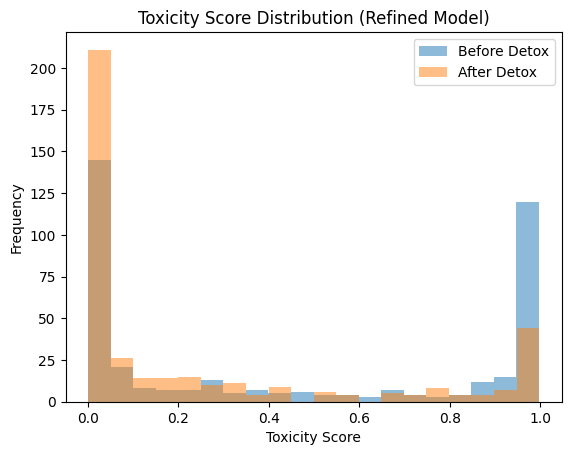

In [44]:
from detoxify import Detoxify

# Load Detoxify model
toxicity_model = Detoxify('unbiased')

# Run toxicity prediction
toxicity_scores = toxicity_model.predict(input_texts)
detoxified_scores = toxicity_model.predict(detoxified_outputs)

# Print sample comparisons
for i in range(3):
    print(f"Original:    {input_texts[i]}")
    print(f"Detoxified:  {detoxified_outputs[i]}")
    print(f"Toxicity Before: {toxicity_scores['toxicity'][i]:.2f}")
    print(f"Toxicity After:  {detoxified_scores['toxicity'][i]:.2f}")
    print("-" * 50)


import numpy as np
import matplotlib.pyplot as plt

# Calculate average toxicity
avg_toxicity_before = np.mean(toxicity_scores['toxicity'])
avg_toxicity_after = np.mean(detoxified_scores['toxicity'])

print(f"Average Toxicity Before: {avg_toxicity_before:.2f}")
print(f"Average Toxicity After: {avg_toxicity_after:.2f}")

# Plotting the distributions
plt.hist(toxicity_scores['toxicity'], bins=20, alpha=0.5, label='Before Detox')
plt.hist(detoxified_scores['toxicity'], bins=20, alpha=0.5, label='After Detox')
plt.xlabel('Toxicity Score')
plt.ylabel('Frequency')
plt.title('Toxicity Score Distribution (Refined Model)')
plt.legend()
plt.show()


In [29]:
from scipy.stats import ttest_rel

# Example: compare two arrays of toxicity scores
before = np.array(toxicity_scores['toxicity'])
after = np.array(detoxified_scores['toxicity'])

t_stat, p_value = ttest_rel(before, after)
print(f"t = {t_stat:.3f}, p = {p_value:.5f}")

t = 30.232, p = 0.00000
